# Programming assignment 1
Following the first problem in the written assignment, set $ρ_{22}$ = 1 and zeros in else- where, solve the system u.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import dia_array  # if dia_array is not able, use dia_matrix
from scipy.sparse import dia_matrix
from numba import jit, njit, prange, set_num_threads

# Set the number of threads to use for numba
nthreads = 8
set_num_threads(nthreads)

In [2]:
def generate_the_laplace_matrix_with_size(N=4):
    """
    assume sqrt(N) is an integer.

    N is the number of grid points in one direction.

    """
    nsq = N*N
    A   = np.zeros((nsq,nsq))

    def init_1_4_1_matrix(N=4):
        ex = np.ones(nsq)
        data = np.array([-ex, 4 * ex, -ex])
        offset = np.array([-1, 0, 1])
        u = dia_matrix((data, offset), shape=(N, N)).toarray()
        return u

    def init_one_matrix(N):
        return -np.identity(N)

    def init_zero_matrix(N):
        return np.zeros((N,N))
    
    d_matrix = init_1_4_1_matrix(N)
    o_matrix = init_one_matrix(N)
    z_matrix = init_zero_matrix(N)
    
    '''
    for i in range(N):
        for j in range(N):
            if i == j:
                submartix = init_1_4_1_matrix(N)
            elif abs(i-j) == 1:
                submartix = init_one_matrix(N)
            else:
                submartix = init_zero_matrix(N)
            
            for ii in range(N):
                for jj in range(N):
                    A[i*N+ii][j*N+jj] = submartix[ii][jj]
    '''
    A = init_matrix_kernel(N, A, d_matrix, o_matrix, z_matrix)
    return A

# use numba to speed up the matrix generation
@njit(parallel=True)
def init_matrix_kernel(N,A,d_matrix,o_matrix, z_matrix):
    for i in prange(N):
        for j in prange(N):
            if (i==j):
                submatrix = d_matrix
            elif (abs(i-j)==1):
                submatrix = o_matrix
            else:
                submatrix = z_matrix
            
            for i2 in range(N):
                for j2 in range(N):
                    ii = i2 + i*N
                    jj = j2 + j*N
                    A[ii,jj] = submatrix[i2,j2]   
    return A

# include boundary conditions
def generate_the_rhs_vector_with_size(N=3):
    b = np.zeros(N*N)
    b[4] = 1
    return b

# convert the solution vector to the finite difference grids u[i,j]
def convert_solution(x):
    usize = np.sqrt(len(x))
    u = x.reshape(int(usize),int(usize)).transpose()
    return u

In [3]:
# check the format of A & b
N = 3
A = generate_the_laplace_matrix_with_size(N)
print(A)
b = generate_the_rhs_vector_with_size(N)
print(b)

[[ 4. -1.  0. -1. -0. -0.  0.  0.  0.]
 [-1.  4. -1. -0. -1. -0.  0.  0.  0.]
 [ 0. -1.  4. -0. -0. -1.  0.  0.  0.]
 [-1. -0. -0.  4. -1.  0. -1. -0. -0.]
 [-0. -1. -0. -1.  4. -1. -0. -1. -0.]
 [-0. -0. -1.  0. -1.  4. -0. -0. -1.]
 [ 0.  0.  0. -1. -0. -0.  4. -1.  0.]
 [ 0.  0.  0. -0. -1. -0. -1.  4. -1.]
 [ 0.  0.  0. -0. -0. -1.  0. -1.  4.]]
[0. 0. 0. 0. 1. 0. 0. 0. 0.]


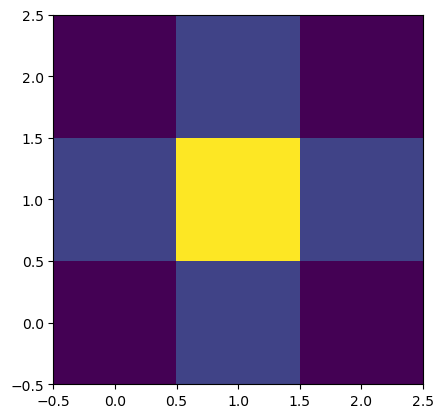

In [4]:
from scipy import linalg
x = linalg.solve(A, b)
u1 = convert_solution(x)
plt.imshow(u1.T,origin="lower")